## COVID-19 FORECAST USING KUBEFLOW FAIRING ON UCS

## Clone Cisco Kubeflow starter pack repository

In [7]:
BRANCH_NAME="master" #Provide git branch "master" or "dev"
! git clone -b $BRANCH_NAME https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

Cloning into 'cisco-kubeflow-starter-pack'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (216/216), done.
remote: Total 3056 (delta 102), reused 231 (delta 48), pack-reused 2709
Receiving objects: 100% (3056/3056), 10.79 MiB | 34.97 MiB/s, done.
Resolving deltas: 100% (1169/1169), done.


## Set Docker Registry user name
The Docker Registry user name variable is used to push the newly built image. 

In [4]:
DOCKER_REGISTRY = "poornimadevii"

## Configure Docker credentials

Get your Docker registry user name and password encoded in base64 

echo -n $DOCKER_REGISTRY:PASSWORD | base64 

Create a config.json file with your Docker registry url and the previous generated base64 string 

In [ ]:
!echo -n $DOCKER_REGISTRY:PASSWORD | base64

In [ ]:
%%writefile config.json
{
    "auths": {
        "https://index.docker.io/v1/": {
            "auth": "<<Provide previous generated base64 string>>"
        }
    }
}

## Create requirements.txt

In [47]:
%%writefile requirements.txt
pandas
keras
seldon-core
tornado>=6.0.3
kubeflow-fairing
tensorflow==1.13.1
cloudpickle==1.1.1
kubernetes==10.0.1
matplotlib

Overwriting requirements.txt


## Install requirements

In [48]:
!pip install --user -r requirements.txt

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Restart Notebook kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import re,os
import logging
import sys
import importlib
import time
import tensorflow as tf
import keras
from keras.models import Model
from keras import layers
from keras import Input
from keras import optimizers

from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: 

## Set up Kubeflow Fairing for training and predictions on On-premise
Import the fairing library and configure the onprem environment that your training or prediction job will run in.

In [2]:
from kubernetes import client as k8s_client
from kubernetes.client import rest as k8s_rest
from kubernetes import config as k8s_config
from kubernetes.client.rest import ApiException

from kubeflow import fairing   
from kubeflow.fairing import utils as fairing_utils
from kubeflow.fairing import TrainJob
from kubeflow.fairing.preprocessors.function import FunctionPreProcessor
from kubeflow.fairing.preprocessors import base as base_preprocessor
from kubeflow.fairing.builders.cluster.cluster import ClusterBuilder

from kubeflow.fairing.cloud.k8s import MinioUploader
from kubeflow.fairing.builders.cluster.minio_context import MinioContextSource
from kubeflow.fairing import PredictionEndpoint
from kubeflow.fairing.kubernetes.utils import mounting_pvc
from kubeflow.fairing.kubernetes.utils import mounting_pvc

BackendClass = getattr(importlib.import_module('kubeflow.fairing.backends'), "KubernetesBackend")
namespace = fairing_utils.get_current_k8s_namespace()
print("Namespace : %s"%namespace)

Namespace : anonymous


## Get minio-service cluster IP to upload docker build context


In [3]:
k8s_config.load_incluster_config()
api_client = k8s_client.CoreV1Api()
custom_api=k8s_client.CustomObjectsApi()
minio_service_endpoint = None

try:
    minio_service_endpoint = api_client.read_namespaced_service(name='minio-service', namespace='kubeflow').spec.cluster_ip
except ApiException as e:
    if e.status == 403:
        logging.warning(f"The service account doesn't have sufficient privileges "
                      f"to get the kubeflow minio-service. "
                      f"You will have to manually enter the minio cluster-ip. "
                      f"To make this function work ask someone with cluster "
                      f"priveleges to create an appropriate "
                      f"clusterrolebinding by running a command.\n"
                      f"kubectl create --namespace=kubeflow rolebinding "
                       "--clusterrole=kubeflow-view "
                       "--serviceaccount=${NAMESPACE}:default-editor "
                       "${NAMESPACE}-minio-view")
        logging.error("API access denied with reason: {e.reason}")

s3_endpoint = minio_service_endpoint
minio_endpoint = "http://"+s3_endpoint+":9000"
minio_username = "minio"
minio_key = "minio123"
minio_region = "us-east-1"
print(minio_endpoint)


minio_uploader = MinioUploader(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)
minio_context_source = MinioContextSource(endpoint_url=minio_endpoint, minio_secret=minio_username, minio_secret_key=minio_key, region_name=minio_region)

http://10.98.188.38:9000


## Create a config-map in the namespace you're using with the docker config

In [8]:
!kubectl create --namespace $namespace configmap docker-config --from-file=./config.json

configmap/docker-config created


## Define required paths to train & test data files

In [9]:
main_path = 'cisco-kubeflow-starter-pack/apps/healthcare/covid-forecasting/onprem/'
train_data_path = main_path + 'data/train.csv'
test_data_path = main_path + 'data/test.csv'

## Build Docker image

In [10]:
output_map= {
    os.path.join(main_path, "fairing/Dockerfile"): "Dockerfile",
    os.path.join(main_path, "fairing/covid-model.py"):"covid-model.py",
    os.path.join(train_data_path): "train.csv",
    os.path.join(test_data_path): "test.csv"
}

preprocessor = base_preprocessor.BasePreProcessor(output_map=output_map, input_files=['requirements.txt'])

preprocessor.preprocess()
builder = ClusterBuilder(registry=DOCKER_REGISTRY, preprocessor=preprocessor, context_source=minio_context_source)

builder.build()

[I 200515 06:16:08 cluster:46] Building image using cluster builder.
[I 200515 06:16:08 base:107] Creating docker context: /tmp/fairing_context_jzhqbrjd
[W 200515 06:16:08 base:94] /tmp/fairing_dockerfile_tokrvlfg already exists in Fairing context, skipping...
[W 200515 06:16:08 manager:296] Waiting for fairing-builder-zb65s-wl4sp to start...
[W 200515 06:16:08 manager:296] Waiting for fairing-builder-zb65s-wl4sp to start...
[W 200515 06:16:08 manager:296] Waiting for fairing-builder-zb65s-wl4sp to start...
[W 200515 06:16:11 manager:296] Waiting for fairing-builder-zb65s-wl4sp to start...
[I 200515 06:16:12 manager:302] Pod started running True


INFO[0001] Resolved base name python:3.7-slim-buster to python:3.7-slim-buster
INFO[0001] Resolved base name python:3.7-slim-buster to python:3.7-slim-buster
INFO[0001] Downloading base image python:3.7-slim-buster
INFO[0002] Error while retrieving image from cache: getting file info: stat /cache/sha256:94f8a1f7d40d9967577e460c7457e978ffb7e12b22fdf4dc7337bd1c53b92e9c: no such file or directory
INFO[0002] Downloading base image python:3.7-slim-buster
INFO[0003] Built cross stage deps: map[]
INFO[0003] Downloading base image python:3.7-slim-buster
INFO[0004] Error while retrieving image from cache: getting file info: stat /cache/sha256:94f8a1f7d40d9967577e460c7457e978ffb7e12b22fdf4dc7337bd1c53b92e9c: no such file or directory
INFO[0004] Downloading base image python:3.7-slim-buster
INFO[0005] Unpacking rootfs as cmd RUN pip install tensorflow==1.13.1 --no-cache-dir requires it.
INFO[0008] Taking snapshot of full filesystem...
INFO[0010] RUN pip install tensorflow==1.13.1 --no-cache-dir
I

In [11]:
builder.image_tag

'poornimadevii/fairing-job:DD24F1F6'

## Create Katib experiment

In [12]:
experiment={
  "apiVersion": "kubeflow.org/v1alpha3",
  "kind": "Experiment",
  "metadata": {
    "namespace": "anonymous",
    "labels": {
      "controller-tools.k8s.io": "1.0"
     
    },
    "name": "covid"
  },
  "spec": {
    "objective": {
      "type": "maximize",
      "goal": 0.99,
      "objectiveMetricName": "Accuracy"
  },
    "algorithm": {
      "algorithmName": "bayesianoptimization"
    },
    "parallelTrialCount": 4,
    "maxTrialCount": 12,
    "maxFailedTrialCount": 4,
    "parameters": [
      {
        "name": "--batch-size",
        "parameterType": "categorical",
        "feasibleSpace": {
          "list": [
            "16",
            "32",
            "48",
            "64"
          ]
        }
      },
     {
        "name": "--optimizer",
        "parameterType": "categorical",
        "feasibleSpace": {
          "list": [
            "adam",
            "sgd"
          ]
        }
      }    
    ],
    "trialTemplate": {
      "goTemplate": {
        "rawTemplate": "apiVersion: batch/v1\nkind: Job\nmetadata:\n  name: {{.Trial}}\n  namespace: {{.NameSpace}}\nspec:\n  template:\n    spec:\n      containers:\n      - name: {{.Trial}}\n        image: %s\n        command:\n        - \"python3\"\n        - \"/opt/covid-model.py\"\n        {{- with .HyperParameters}}\n        {{- range .}}\n        - \"{{.Name}}={{.Value}}\"\n        {{- end}}\n        {{- end}}\n      restartPolicy: Never"%builder.image_tag
      }
    }
  }
}

experiment_name=experiment["metadata"]["name"]
custom_api.create_namespaced_custom_object(group="kubeflow.org", version="v1alpha3", namespace=namespace, plural="experiments", body=experiment)

{'apiVersion': 'kubeflow.org/v1alpha3',
 'kind': 'Experiment',
 'metadata': {'creationTimestamp': '2020-05-15T06:18:53Z',
  'generation': 1,
  'labels': {'controller-tools.k8s.io': '1.0'},
  'name': 'covid',
  'namespace': 'anonymous',
  'resourceVersion': '10206539',
  'selfLink': '/apis/kubeflow.org/v1alpha3/namespaces/anonymous/experiments/covid',
  'uid': 'c3ad86ca-e7a0-47ac-9bfb-4b15def40295'},
 'spec': {'algorithm': {'algorithmName': 'bayesianoptimization'},
  'maxFailedTrialCount': 4,
  'maxTrialCount': 12,
  'metricsCollectorSpec': {'collector': {'kind': 'StdOut'}},
  'objective': {'goal': 0.99,
   'objectiveMetricName': 'Accuracy',
   'type': 'maximize'},
  'parallelTrialCount': 4,
  'parameters': [{'feasibleSpace': {'list': ['16', '32', '48', '64']},
    'name': '--batch-size',
    'parameterType': 'categorical'},
   {'feasibleSpace': {'list': ['adam', 'sgd']},
    'name': '--optimizer',
    'parameterType': 'categorical'}],
  'trialTemplate': {'goTemplate': {'rawTemplate': '

## Wait for experiment succeeded status

In [13]:
status=False
while True:
    conditions=custom_api.get_namespaced_custom_object_status(group="kubeflow.org", version="v1alpha3", namespace=namespace, plural="experiments", name=experiment["metadata"]["name"])["status"]["conditions"]
    for i in range(len(conditions)):
        if (conditions[i]['type'])=='Succeeded':
            status=True
            print("Experiment Status: %s"%conditions[i]['type'])
            break
        
    if status:
        break
    print("Experiment Status: %s"%conditions[i]['type'])
    time.sleep(60)

Experiment Status: Created
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Running
Experiment Status: Succeeded


## Get optimal hyperparameters

In [14]:
tuning_params=custom_api.get_namespaced_custom_object("kubeflow.org", "v1alpha3", namespace, "experiments", experiment["metadata"]["name"])["status"]["currentOptimalTrial"]["parameterAssignments"]
tuning_params

[{'name': '--batch-size', 'value': '48'},
 {'name': '--optimizer', 'value': 'adam'}]

## Get PVC name

In [15]:
pvcname = !(echo  $HOSTNAME | sed 's/.\{2\}$//')
pvc = "workspace-"+pvcname[0]
print(pvc)

workspace-poornima


## Preprocess dataset

#### Define function for preprocessing train data

In [16]:
def preprocess_train(train_df, n_prev, n_next):
    df = train_df.copy()
    input_feats, output_feats = [], []
    
    # Performing Shifting of Previous cases in the positive direction (downwards) for New cases & New Fatalities
    for i in range(1, n_prev+1):
        for feat in ["NewCases", "NewFatalities"]:
            df["{}_prev_{}".format(feat, i)] = df.groupby(["Country_Region", "Province_State"])[feat].shift(i)
            input_feats.append("{}_prev_{}".format(feat, i))
    
    # Performing Shifting of Next Cases in the negative direction (upwards) for New cases & New Fatalities
    output_feats.extend(["NewCases", "NewFatalities"])
    for i in range(1, n_next):
        for feat in ["NewCases", "NewFatalities"]:
            df["{}_next_{}".format(feat, i)] = df.groupby(["Country_Region", "Province_State"])[feat].shift(-i)
            output_feats.append("{}_next_{}".format(feat, i))
    df.dropna(inplace=True)     
    
    #Converting the Province state & Country Region to Dummy/Indicator Variables ( which is a constant)
    const_df = pd.get_dummies(df[["Province_State", "Country_Region"]], drop_first=True)
    
    # Assigning already available data for previous no of days counting back from starting date of forecasting dates
    time_df = df[input_feats]
    time_df = time_df.values.reshape((df.shape[0],-1,2))
    
    #Assigning values to the future no of days counting forth from the starting date of forecasting dates
    output_df = df[output_feats]
    return const_df, time_df, output_df

#### Define function for preprocessing test data

In [17]:
def preprocess_test(train_df, test_df, n_prev):
    input_feats = []
    
    #Appending the training data with test data records with date of specified no of forecasting dates
    append_df = pd.concat([train_df, test_df[test_df["Date"] == train_df["Date"].max() + timedelta(days=1)]])
    
    #Sorting the Dataframe in ascending order of Country region, province state & Date
    append_df.sort_values(["Country_Region", "Province_State", "Date"], ascending=[True, True, True], inplace=True)
    
    # Performing Shifting of Previous cases in the positive direction (downwards) for New cases & New Fatalities
    for i in range(1, n_prev+1):
        for feat in ["NewCases", "NewFatalities"]:
            append_df["{}_prev_{}".format(feat, i)] = append_df.groupby(["Country_Region", "Province_State"])[feat].shift(i)
            input_feats.append("{}_prev_{}".format(feat, i))
            
    # Adding a column of ForecastId if records are not having null values        
    append_df = append_df[append_df["ForecastId"].notnull()]
    
    #Converting the Province state & Country Region to Dummy/Indicator Variables ( which is a constant)
    const_df = pd.get_dummies(append_df[["Province_State", "Country_Region"]], drop_first=True)
    
    # Assigning already available data for previous no of days counting back from starting date of forecasting dates
    time_df = append_df[input_feats]
    time_df = time_df.values.reshape((append_df.shape[0],-1,2))
    
    return const_df, time_df


#### Define main preprocessing function

In [18]:
def covid_preprocess_function():
        
        # Read train and test datasets
        train_df = pd.read_csv(train_data_path)
        print("train_df shape: {0}" .format(train_df.shape))
        test_df = pd.read_csv(test_data_path)
        print("train_df shape: {0}" .format(test_df.shape))

        # Check the NaN value status in each column of the Train data
        # Checking whether no column except Province_State are having NaN values
        train_df.apply(lambda col: col.isnull().value_counts(), axis=0)
        test_df.apply(lambda col: col.isna().value_counts(), axis=0)

        # Replace the values of NaN with ""
        train_df["Province_State"] = train_df["Province_State"].fillna("")
        test_df["Province_State"] = test_df["Province_State"].fillna("")

        # Convert the Date column values to Pandas Datetime format
        train_df["Date"] = pd.to_datetime(train_df["Date"])
        test_df["Date"] = pd.to_datetime(test_df["Date"])

        # Add New Columns for "NewCases" and Fill the Column with difference values from the previous rows
        train_df["NewCases"] = train_df.groupby(["Country_Region", "Province_State"])["ConfirmedCases"].diff(periods=1)

        # Replace "NewCases" NaN values with 0
        train_df["NewCases"] = train_df["NewCases"].fillna(0)

        # Ensure that the NewCases are not negative. If NewCases are negative then they are replaced with zero else the actual value is provided
        train_df["NewCases"] = np.where(train_df["NewCases"] < 0, 0, train_df["NewCases"])

        # Add a column for "NewFatalities" same as for "NewCases"
        train_df["NewFatalities"] = train_df.groupby(["Country_Region", "Province_State"])["Fatalities"].diff(periods=1)
        train_df["NewFatalities"] = train_df["NewFatalities"].fillna(0)
        train_df["NewFatalities"] = np.where(train_df["NewFatalities"] < 0, 0, train_df["NewFatalities"])

        # Apply Natural Logarithmic Function to NewCases and NewFatalities Column
        train_df["NewCases"] = np.log(train_df["NewCases"] + 1)
        train_df["NewFatalities"] = np.log(train_df["NewFatalities"] + 1)
        
        #Calculate the number of days for which forecasting of New Cases & New Fatalities needs to be performed
        n_next = (test_df["Date"].max() - train_df["Date"].max()).days
        #print("No of Future Days requested to forecast COVID-19 New Cases & New Fatalities:", n_next)
        
        const_df, time_df, output_df = preprocess_train(train_df, n_next, n_next)
        
        const_test_df, time_test_df = preprocess_test(train_df, test_df, n_next)
        
        return (train_df, test_df, const_df, time_df, output_df, const_test_df, time_test_df)
        
        
train_df, test_df, const_df, time_df, output_df, const_test_df, time_test_df = covid_preprocess_function()        

train_df shape: (28170, 6)
train_df shape: (13459, 4)


#### Define function for creating & training model

In [19]:
def covid_model_train_function(model_export_path, epochs, batch_size):
    
    time_input = Input(shape=(time_df.shape[1], time_df.shape[2]))
    lstm = layers.LSTM(64)(time_input)

    const_input = Input(shape=(const_df.shape[1],))

    combine = layers.concatenate([lstm, const_input], axis=-1)
    #lstm_out = layers.Dropout(0.1)(combine)
    output = layers.Dense(output_df.shape[1], activation='softmax')(combine)

    model = Model([time_input, const_input], output)
    #optimizer=optimizers.SGD(lr=0.01, nesterov=True)
    model.compile(optimizer=tuning_params[1]["value"],loss='mean_squared_error',metrics=['acc'])
    model.summary()
    
    model.fit([time_df, const_df], output_df, epochs=epochs, batch_size=int(tuning_params[0]["value"]))
    
    
    input_names = ['input1','input2']
    name_to_input = {name: t_input for name, t_input in zip(input_names, model.inputs)}
    

    tf.saved_model.simple_save(
        keras.backend.get_session(),
        os.path.join(model_export_path, "001"),
        inputs=name_to_input,
        outputs={t.name: t for t in model.outputs})    
    

## Define COVID class to be used for Kubeflow Fairing

In [20]:
class CovidServe(object):
    
    def __init__(self):
            self.model = None
            self.model_export_path = '/mnt/covid-model'
            self.epochs = 5
            self.batch_size = 64
                 

    def train(self):
         covid_model_train_function(self.model_export_path, self.epochs, self.batch_size)
         
    def predict(self,X,feature_names=None):
         
        path=os.path.join(os.getcwd(), self.model_export_path)
        for dir in os.listdir(path):
            if re.match('[0-9]',dir):
                exported_path=os.path.join(path,dir)
                break
                
        global output_dict
        import logging
        # Open a Session to predict
        with tf.Session() as sess:
            tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], exported_path)
            predictor= tf.contrib.predictor.from_saved_model(exported_path,signature_def_key='serving_default')
            input_data1=[]
            input_data2=[]
            for i in range(len(X[0])):
                input_data1.append(X[0][i])
                input_data2.append(X[1][i])
            output_dict= predictor({"input1": input_data1, "input2": input_data2})
            
        sess.close()
        return output_dict["dense_1/Softmax:0"]


## Train COVID model on Kubeflow using Kubeflow Fairing
Kubeflow Fairing packages the CovidServe class, the training data, and the training job's software prerequisites as a Docker image. Then Kubeflow Fairing deploys and runs the training job on kubeflow.

In [22]:
train_job = TrainJob(CovidServe, input_files=[train_data_path, test_data_path,"requirements.txt"],
                     pod_spec_mutators = [mounting_pvc(pvc_name=pvc, pvc_mount_path="/mnt/")],
                     docker_registry=DOCKER_REGISTRY, backend=BackendClass(build_context_source=minio_context_source))
train_job.submit()

[W 200515 06:41:35 tasks:54] Using default base docker image: registry.hub.docker.com/library/python:3.6.9
[W 200515 06:41:35 tasks:62] Using builder: <class 'kubeflow.fairing.builders.cluster.cluster.ClusterBuilder'>
[I 200515 06:41:35 tasks:66] Building the docker image.
[I 200515 06:41:35 cluster:46] Building image using cluster builder.
[W 200515 06:41:35 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[I 200515 06:41:35 base:107] Creating docker context: /tmp/fairing_context_4mf0qi7j
[W 200515 06:41:35 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[W 200515 06:41:36 manager:296] Waiting for fairing-builder-gpnqj-xk84x to start...
[W 200515 06:41:36 manager:296] Waiting for fairing-builder-gpnqj-xk84x to start...
[W 200515 06:41:36 manager:296] Waiting for fairing-builder-gpnqj-xk84x to start...
[W 200515 06:41:3

INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0002] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0002] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Built cross stage deps: map[]
INFO[0004] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0004] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0005] Unpacking rootfs as cm

  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427965 sha256=55666ef443eee6ed51cc6785c66baac49f2d2eeb58fda3f3b86ba6003a9ef858
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=480469 sha256=0f4146ac2c5fb5e1b01867141f2601f9135e8873e419825ba32358e7c98f48d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for jaeger-client: filename=jaeger_client-4.1.0-cp36-none-any.whl size=64309 sha256=f6e0e11257446416e0e174ab9f7ac719290a1b65bfda8c3b5988a1a7d41d6180
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/f2/84/7f/e89da3ee8ce35598d6382b6389fa2ada5d66acca2422537994
  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp36-none-any.whl size=41402 sha256=008c34380decc3d543fb177

  Created wheel for threadloop: filename=threadloop-1.0.2-cp36-none-any.whl size=3425 sha256=3c783cd3de70eabbebac6f0ef559b0a07d46839a9adbc377313cb74c4142a93b
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/d7/7a/30/d212623a4cd34f6cce400f8122b1b7af740d3440c68023d51f
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=483916 sha256=069adb273d71b478e45ea59bdab58e6e12dd16a292e88a2aa8c785823a49710a
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.6.2-py2.py3-none-any.whl size=462042 sha256=6fcb86a6caafbb06cc2bed5f803a8cbd375e72b2ac3773e0e6734ec018e9b87b
  Stored in directory: /tmp/pip-ephem-wheel-cache-b85c_yle/wheels/16/82/37/f124bfe619e72fc1c5f9abbd018bf2ee129f131bf2ede5ebcc
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.6.2-py2.py3-none-any.whl size=88602 sha256=416bb

INFO[0137] Using files from context: [/kaniko/buildcontext/app]
INFO[0137] COPY /app/ /app/
INFO[0137] Taking snapshot of files...


[W 200515 06:44:55 job:101] The job fairing-job-nqmp8 launched.
[W 200515 06:44:55 manager:296] Waiting for fairing-job-nqmp8-zzsjv to start...
[W 200515 06:44:55 manager:296] Waiting for fairing-job-nqmp8-zzsjv to start...
[W 200515 06:44:55 manager:296] Waiting for fairing-job-nqmp8-zzsjv to start...
[W 200515 06:44:57 manager:296] Waiting for fairing-job-nqmp8-zzsjv to start...
[I 200515 06:45:32 manager:302] Pod started running True


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

13459/13459 [==============================] - 8s 563us/step - loss: 3.9010 - acc: 0.1349
Epoch 2/5

 1296/13459 [=>............................] - ETA: 6s - loss: 3.6595 - acc: 0.1782


11808/13459 [=========================>....] - ETA: 0s - loss: 3.8905 - acc: 0.1518


13459/13459 [==============================] - 7s 544us/step - loss: 3.8961 - acc: 0.1505
Epoch 3/5

 8304/13459 [=================>............] - ETA: 2s - loss: 3.9152 - acc: 0.1569


13459/13459 [==============================] - 8s 584us/step - loss: 3.8959 - acc: 0.1537
Epoch 4/5

 5328/13459 [==========>...................] - ETA: 4s - loss: 4.0408 - acc: 0.1545


13459/13459 [==============================] - 7s 556us/step - loss: 3.8959 - acc: 0.1519
Epoch 5/5

 1824/13459 [===>..........................] - ETA: 6s - loss: 4.1189 - acc: 0.1519


12624/13459 [===========================>..] - ETA: 0s - loss: 3.9033 - acc: 0.1520


13459/13459 [==============================] - 7s 542us/step - loss: 3.8958 - acc: 0.1531
From <ipython-input-19-9cfb008fbb9f>:28: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
From /usr/local/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:205: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Assets added to graph.
No assets to write.
SavedModel written to: /mnt/covid-model/001/saved_model.pb


[W 200515 06:46:14 job:173] Cleaning up job fairing-job-nqmp8...


'fairing-job-nqmp8'

## Deploy trained model to Kubeflow for predictions using Kubeflow Fairing
Kubeflow Fairing packages the CovidServe class, the trained model, and the prediction endpoint's software prerequisites as a Docker image. Then Kubeflow Fairing deploys and runs the prediction endpoint on Kubeflow.

In [23]:
endpoint = PredictionEndpoint(CovidServe, input_files=[train_data_path, test_data_path,"requirements.txt"],
                              docker_registry=DOCKER_REGISTRY,
                              pod_spec_mutators = [mounting_pvc(pvc_name=pvc, pvc_mount_path="/mnt/")],
                              backend=BackendClass(build_context_source=minio_context_source))
endpoint.create()

[W 200515 06:49:39 tasks:54] Using default base docker image: registry.hub.docker.com/library/python:3.6.9
[W 200515 06:49:39 tasks:62] Using builder: <class 'kubeflow.fairing.builders.cluster.cluster.ClusterBuilder'>
[I 200515 06:49:39 tasks:66] Building the docker image.
[I 200515 06:49:39 cluster:46] Building image using cluster builder.
[W 200515 06:49:39 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[I 200515 06:49:39 base:107] Creating docker context: /tmp/fairing_context_81e4qubg
[W 200515 06:49:39 base:94] /home/jovyan/.local/lib/python3.6/site-packages/kubeflow/fairing/__init__.py already exists in Fairing context, skipping...
[W 200515 06:49:41 manager:296] Waiting for fairing-builder-4pgbw-72vzs to start...
[W 200515 06:49:41 manager:296] Waiting for fairing-builder-4pgbw-72vzs to start...
[W 200515 06:49:41 manager:296] Waiting for fairing-builder-4pgbw-72vzs to start...
[W 200515 06:49:4

INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Resolved base name registry.hub.docker.com/library/python:3.6.9 to registry.hub.docker.com/library/python:3.6.9
INFO[0001] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0002] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0002] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0003] Built cross stage deps: map[]
INFO[0003] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0003] Error while retrieving image from cache: getting file info: stat /cache/sha256:036d4ab50fa49df89e746cf1b5369c88db46e8af2fbd08531788e7d920e9a491: no such file or directory
INFO[0003] Downloading base image registry.hub.docker.com/library/python:3.6.9
INFO[0004] Unpacking rootfs as cm

  Created wheel for tornado: filename=tornado-6.0.4-cp36-cp36m-linux_x86_64.whl size=427968 sha256=7c18ccad08ac4c7e87b7bf64e0d0d56abbb1055e0be5e664b681102e23dbe0f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/93/84/2f/409c7b2bb3afc3aa727f7ee8787975e0793f74d1165f4d0104
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=480461 sha256=ef21ac1810b0b95a2994eef8d3716aa0fb95ff110d1088c66cb3ad518aca8ebe
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp36-none-any.whl size=41402 sha256=c3ab016abeb9c8a7ab08820d738a25ea8649e2fed053e4531b8adc2023ac2db5
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
  Created wheel for opentracing: filename=opentracing-2.2.0-cp36-none-any.whl size=49320 sha256=ba31c471328ba1b7c6f195c550f

  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=483931 sha256=418f4bc9f04364900292614872494fce17fe093604da401b4c557c0105cd0adf
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/02/a2/46/689ccfcf40155c23edc7cdbd9de488611c8fdf49ff34b1706e
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.6.2-py2.py3-none-any.whl size=462042 sha256=4cd1bc61e4d72707b75896c04fa4cf3e06903a1732101b20f3dbd261ee983db9
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/16/82/37/f124bfe619e72fc1c5f9abbd018bf2ee129f131bf2ede5ebcc
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.6.2-py2.py3-none-any.whl size=88602 sha256=a88e394b4d7890b68df39e1f1debc64bbb8545a6700aac54672b9aaaefae7939
  Stored in directory: /tmp/pip-ephem-wheel-cache-cps0adw6/wheels/49/c8/20/8139a0a66f56909d5e96bfa423067020e6b5736c3a5b53f51c
  Created wheel for googleapis-common-protos: filename=googleapis_common_protos-1.51.0-cp36-none-a

[I 200515 06:52:58 tasks:100] Deploying the endpoint.
[I 200515 06:52:58 serving:74] Cluster endpoint: http://fairing-service-g8s7c.anonymous.svc.cluster.local:5000/predict
[W 200515 06:52:58 tasks:106] Prediction endpoint: http://fairing-service-g8s7c.anonymous.svc.cluster.local:5000/predict


## Obtain URL of prediction endpoint 

In [24]:
url = endpoint.url
url

'http://fairing-service-g8s7c.anonymous.svc.cluster.local:5000/predict'

## Design input data for prediction using prediction endpoint

In [25]:
input_data={"data":{"ndarray":[time_test_df.tolist(), const_test_df.values.tolist()]}}

## Predict using prediction endpoint
Please wait for few mins to execute this step, as Prediction Endpoint Deployer Pod may take sometime to be up.

In [26]:
import requests
import json
headers = {"Content-Type": "application/x-www-form-urlencoded"}
response=requests.post(url, data={'json':json.dumps(input_data)})
predictions=response.json()["data"]["ndarray"]
print(len(predictions))
print(predictions[0])

313
[7.959990398376249e-06, 2.2672929844702594e-06, 4.854178769164719e-06, 2.1140870103408815e-06, 9.112415682466235e-06, 2.1130167624505702e-06, 1.2564511962409597e-05, 2.6150967187277274e-06, 1.4623164133809041e-05, 3.92113770431024e-06, 1.5002528016339056e-05, 3.3462463306932477e-06, 1.0770339031296317e-05, 3.1551426218356937e-06, 6.845717052783584e-06, 2.406203293503495e-06, 1.7218455468537286e-05, 4.244364390615374e-06, 1.158688792202156e-05, 1.76891956016334e-06, 7.870668014220428e-06, 3.2215357350651175e-06, 3.2451389415655285e-05, 1.479392267356161e-06, 3.159709012834355e-05, 2.103296083078021e-06, 5.728198811993934e-05, 2.447138967909268e-06, 5.080631672171876e-05, 1.80906101832079e-06, 0.00015256866754498333, 2.4707060219952837e-06, 0.00023996722302399576, 2.546054247432039e-06, 0.0011255530407652259, 3.3950316264963476e-06, 0.0467970110476017, 2.6256273031322053e-06, 0.07514587044715881, 1.9744829842238687e-06, 0.13643211126327515, 2.0971731373720104e-06, 0.19224613904953003

## Post-processing prediction results

#### Filter the part of test data with specified future dates and convert the exponential format back to normal values

Also concatenating the predicted new cases & new fatalities to the data

In [27]:
sub_test_df = test_df[test_df["Date"] > train_df["Date"].max()]
sub_test_df = pd.concat([sub_test_df,
                         pd.DataFrame(np.array(predictions).reshape((-1, 2)), columns=["NewCases", "NewFatalities"], index=sub_test_df.index)],
                         axis=1)
sub_test_df["NewCases"] = np.exp(sub_test_df["NewCases"]) - 1
sub_test_df["NewFatalities"] = np.exp(sub_test_df["NewFatalities"]) - 1
# sub_test_df.head()

# Filtering the part of test data with available dates and merging leftout dates if any
fixed_test_df = test_df[test_df["Date"] <= train_df["Date"].max()].merge(train_df[train_df["Date"] >= test_df["Date"].min()][["Province_State","Country_Region", "Date", "ConfirmedCases", "Fatalities"]],
                                                                         how="left", on=["Province_State","Country_Region", "Date"])
fixed_test_df

# Concatenate the fixed_test data with the sub_test data ( which includes predicted New cases & New Fatalities)
predict_df = pd.concat([sub_test_df, fixed_test_df]).sort_values(["Country_Region", "Province_State", "Date"],
                                                                 ascending=[True, True, True])

# Add a new Index column to Predict_df
predict_df = predict_df.reset_index()

# Replace null values of Confirmed Cases & Fatalities using New Cases & New Fatalities by accumulation
for i in range(len(predict_df)):
    if pd.isnull(predict_df.iloc[i]["ConfirmedCases"]):
        predict_df.loc[i, "ConfirmedCases"] = predict_df.iloc[i - 1]["ConfirmedCases"] + predict_df.iloc[i]["NewCases"]
    if pd.isnull(predict_df.iloc[i]["Fatalities"]):
        predict_df.loc[i, "Fatalities"] = predict_df.iloc[i - 1]["Fatalities"] + predict_df.iloc[i]["NewFatalities"]

# Ensure shape of Prediction result is same with test data
assert predict_df.shape[0] == test_df.shape[0]

# Get the Prediction result of Confirmed Cases & Fatalities for the specified future dates
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].to_csv("submission.csv", index=False)
predict_df[["ForecastId", "ConfirmedCases", "Fatalities"]].head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0


### Filter India's data & visualise

#### Visualise Plotly plot showing the overall trend of increasing confirmed cases right from the beginning of spread till the future date

The intersection of the green and the red line shows the breaking point whether the cases starts to increase drastically.

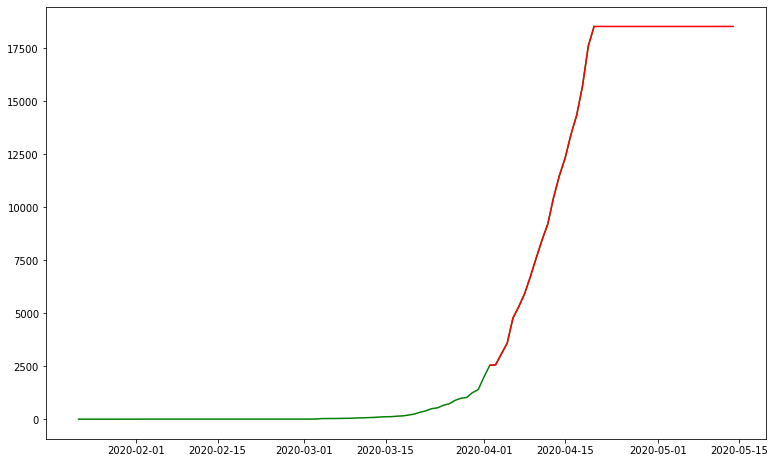

In [28]:
country = "India"

target = "ConfirmedCases"
region_train_df = train_df[(train_df["Country_Region"]==country)]
region_predict_df = predict_df[(predict_df["Country_Region"]==country)]

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_axes([0, 0, 1, 1])
ax1.plot(region_train_df["Date"],
         region_train_df[target],
         color="green")

ax1.plot(region_predict_df["Date"],
         region_predict_df[target],
         color="red")
plt.show()

## Delete prediction endpoint

In [29]:
endpoint.delete()

[I 200515 06:59:08 tasks:130] Deleting the endpoint. 
[I 200515 06:59:08 serving:124] Deleted service: anonymous/fairing-service-g8s7c
[I 200515 06:59:08 serving:136] Deleted deployment: anonymous/fairing-deployer-ssrrt
